In [1]:
%cd ..
%cd diffusion
%pwd

c:\Users\Ene\Desktop\BU\Spring24\Project\EC523_Project_G
c:\Users\Ene\Desktop\BU\Spring24\Project\EC523_Project_G\diffusion


'c:\\Users\\Ene\\Desktop\\BU\\Spring24\\Project\\EC523_Project_G\\diffusion'

In [ ]:
%git clone https://github.com/openai/CLIP
%git clone https://github.com/crowsonkb/guided-diffusion
%pip install -e ./CLIP
%pip install -e ./guided-diffusion
%pip install lpips

In [4]:
!curl -o 256x256_diffusion_uncond.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 2108M    0 2143k    0     0  2154k      0  0:16:42 --:--:--  0:16:42 2156k
  0 2108M    0 17.2M    0     0  8760k      0  0:04:06  0:00:02  0:04:04 8765k
  1 2108M    1 34.8M    0     0  11.6M      0  0:03:01  0:00:02  0:02:59 11.6M
  2 2108M    2 49.8M    0     0  12.4M      0  0:02:49  0:00:03  0:02:46 12.4M
  3 2108M    3 64.0M    0     0  12.7M      0  0:02:45  0:00:05  0:02:40 12.7M
  3 2108M    3 77.8M    0     0  12.9M      0  0:02:42  0:00:06  0:02:36 15.1M
  4 2108M    4 92.0M    0     0  13.0M      0  0:02:41  0:00:07  0:02:34 14.8M
  5 2108M    5  106M    0     0  13.2M      0  0:02:38  0:00:07  0:02:31 14.2M
  5 2108M    5  121M    0     0  13.4M      0  0:02:37  0:00:09  0:02:28 14.1M
  6 2108M    6  136M    0     0  13.6M      0  0:02

In [5]:
# Imports

import gc
import io
import math
import sys

from IPython import display
import lpips
from PIL import Image
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm

sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')

import clip
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

In [26]:
def fetch(path):
    return open(path, 'rb')

def parse_prompt(prompt):
    # return prompt and weight 1.0
    return prompt, float(1)

class MakeCutouts(nn.Module):
    '''
    Generates multiple, variably-sized cutouts from an input image tensor and resizes them to a specified size.
    Do augmentations + resize the image.
    Input:

    An image tensor with dimensions [batch_size, channels, height, width].
    Parameters for the number of cutouts (cutn), the size to which each cutout will be resized (cut_size), and a power value influencing the size distribution of the cutouts (cut_pow).

    Output:

    A tensor containing all the resized cutouts concatenated along the batch dimension, with dimensions [cutn * batch_size, channels, cut_size, cut_size].
    '''
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)
    
def spherical_dist_loss(x, y):
    '''
    Measures the angular distance between vectors on a unit sphere for similarity comparisons.
    Suitable for working in abstract feature space
    '''
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al.
    Total Variation Loss promotes image smoothness by penalizing variations between adjacent pixel values, 
    helping to reduce noise and artifacts in generated or processed images.
    """
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    """
    Pixel values of an image fall within a specified range (e.g., -1 to 1), 
    helping to prevent issues like saturation and clipping in image generation tasks
    """
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

def mse_loss_batch(input, target):
    """
    Compute the Mean Squared Error (MSE) loss between input and target images on a pixel-wise basis for a batch of images.
    """
    if input.shape != target.shape:
        raise ValueError("Input and target must have the same shape")

    # Instantiate the MSE loss function
    mse_loss_function = nn.MSELoss()

    # Compute MSE loss
    return mse_loss_function(input, target)

In [18]:
# Model settings
# Hyperparameters for guided diffusion
model_config = model_and_diffusion_defaults()
model_config.update({
    'attention_resolutions': '32, 16, 8',
    'class_cond': False,
    'diffusion_steps': 1000,
    'rescale_timesteps': True,
    'timestep_respacing': '1000',  # Modify this value to decrease the number of
                                   # timesteps.
    'image_size': 256,
    'learn_sigma': True,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_head_channels': 64,
    'num_res_blocks': 2,
    'resblock_updown': True,
    'use_checkpoint': False,
    'use_fp16': True,
    'use_scale_shift_norm': True,
})

In [19]:
# Load models

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load('256x256_diffusion_uncond.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
if model_config['use_fp16']:
    model.convert_to_fp16()

clip_model = clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device)
clip_size = clip_model.visual.input_resolution
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

#  LPIPS Model for Perceptual Similarity
lpips_model = lpips.LPIPS(net='vgg').to(device)

Using device: cuda:0


100%|███████████████████████████████████████| 335M/335M [00:34<00:00, 10.1MiB/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Ene/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Loading model from: d:\Anaconda\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [20]:
image_prompt_path = "test_image/figure_00000-trans.png"
init_image_path = "test_image/inpainting_00000.png"
ground_true_path = "test_image/ground_true_00000.png"

In [40]:
prompts = ['In the image, a man is seen lying on the gound with snow, with a red hood on his head']
image_prompts = [image_prompt_path] # Image of the character.
ground_trues = ground_true_path # This is the ground truth images.
batch_size = 1
clip_guidance_scale = 500  # Controls how much the image should look like the prompt.
tv_scale = 150              # Controls the smoothness of the final output.
range_scale = 50            # Controls how far out of range RGB values are allowed to be.
cutn = 16
n_batches = 1             # Number of batches to generate. 1 batch = 1 image.
init_image = init_image_path   #  background scene.
skip_timesteps = 0  # This needs to be between approx. 200 and 500 when using an init image.
                    # Higher values make the output look more like the init.
init_scale = 100      # This enhances the effect of the init image, a good value is 1000.
mse_guidance_scale = 300 # Controls how much the image should look like the ground true image.
seed = 0

  0%|          | 0/1000 [00:00<?, ?it/s]


Batch 0, step 0, output 0:


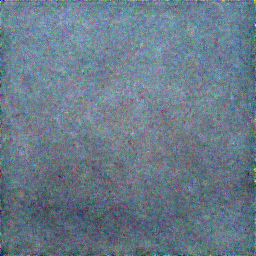

In [41]:
def do_run():
    if seed is not None:
        torch.manual_seed(seed)

    make_cutouts = MakeCutouts(clip_size, cutn)
    side_x = side_y = model_config['image_size']

    target_embeds, weights = [], []

    for prompt in prompts:
        txt, weight = parse_prompt(prompt)
        target_embeds.append(clip_model.encode_text(clip.tokenize(txt).to(device)).float())
        weights.append(weight)

    for prompt in image_prompts:
        path, weight = parse_prompt(prompt)
        img = Image.open(fetch(path)).convert('RGB')
        img = TF.resize(img, min(side_x, side_y, *img.size), transforms.InterpolationMode.LANCZOS)

        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = clip_model.encode_image(normalize(batch)).float()
        target_embeds.append(embed)
        weights.extend([weight / cutn] * cutn)

    target_embeds = torch.cat(target_embeds)
    weights = torch.tensor(weights, device=device)
    if weights.sum().abs() < 1e-3:
        raise RuntimeError('The weights must not sum to 0.')
    weights /= weights.sum().abs()

    init = None
    if init_image is not None:
        init = Image.open(fetch(init_image)).convert('RGB')
        init = init.resize((side_x, side_y), Image.LANCZOS)
        init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)

    ground_truth_img = Image.open(fetch(ground_trues)).convert('RGB')  # Assuming ground_trues contains a single path
    ground_truth_img = ground_truth_img.resize((side_x, side_y), Image.LANCZOS)
    ground_truth_img = TF.to_tensor(ground_truth_img).to(device).unsqueeze(0).mul(2).sub(1)  # Add batch dimension

    cur_t = None

    def cond_fn(x, t, out, y=None):
        n = x.shape[0]
        fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
        x_in = out['pred_xstart'] * fac + x * (1 - fac)
        clip_in = normalize(make_cutouts(x_in.add(1).div(2)))
        image_embeds = clip_model.encode_image(clip_in).float()
        dists = spherical_dist_loss(image_embeds.unsqueeze(1), target_embeds.unsqueeze(0))
        dists = dists.view([cutn, n, -1])
        losses = dists.mul(weights).sum(2).mean(0)
        tv_losses = tv_loss(x_in)
        range_losses = range_loss(out['pred_xstart'])
        
        # Compute the MSE loss with the ground truth
        mse_loss = mse_loss_batch(x_in, ground_truth_img.expand_as(x_in))
        
        loss = losses.sum() * clip_guidance_scale + tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + mse_loss * mse_guidance_scale
        if init is not None and init_scale:
            init_losses = lpips_model(x_in, init)
            loss = loss + init_losses.sum() * init_scale
        return -torch.autograd.grad(loss, x)[0]

    if model_config['timestep_respacing'].startswith('ddim'):
        sample_fn = diffusion.ddim_sample_loop_progressive
    else:
        sample_fn = diffusion.p_sample_loop_progressive

    for i in range(n_batches):
        cur_t = diffusion.num_timesteps - skip_timesteps - 1

        samples = sample_fn(
            model,
            (batch_size, 3, side_y, side_x),
            clip_denoised=False,
            model_kwargs={},
            cond_fn=cond_fn,
            progress=True,
            skip_timesteps=skip_timesteps,
            init_image=init,
            randomize_class=True,
            cond_fn_with_grad=True,
        )

        for j, sample in enumerate(samples):
            cur_t -= 1
            if j % 100 == 0 or cur_t == -1:
                print()
                for k, image in enumerate(sample['pred_xstart']):
                    filename = f'progress_{i * batch_size + k:05}.png'
                    TF.to_pil_image(image.add(1).div(2).clamp(0, 1)).save(filename)
                    tqdm.write(f'Batch {i}, step {j}, output {k}:')
                    display.display(display.Image(filename))

gc.collect()
do_run()